In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter
from community import community_louvain
from matplotlib.cm import ScalarMappable
from sklearn.metrics import adjusted_rand_score
import random
import os
import json
from matplotlib.cm import ScalarMappable
from itertools import combinations, product
from sklearn.metrics import jaccard_score
import numpy as np


### Prepare the Network and Data

We import all the json files we created in the data fetching part intoa single dictionary called 'all_data', and access each specific json fuile by using their file name as the first key of the dictionary.

In [3]:
data_folder_path = '../data/'

all_data = {}

for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        json_file_path = os.path.join(data_folder_path, filename)
        
        with open(json_file_path, 'r') as file:
            all_data[os.path.splitext(filename)[0]] = json.load(file)

We add the character sentiment scores that we have calcukated previously into the character attributes data:

In [4]:
characters_infobox = all_data['characters_infobox']
sentiment_scores_characters = all_data['sentiment_scores_charachters']

for character, info in characters_infobox.items():
    if character in sentiment_scores_characters:
        info['Sentiment Score'] = sentiment_scores_characters[character]


And finally build the cumulative character co-occurance networks for each episode:

In [5]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    """
    Create a character interaction graph(s) from episode data.

    Parameters:
    - data (dict): Dictionary containing episode data, where keys are season names
                  and values are lists of episode data dictionaries.
    - season (str): If specified, create a character interaction graph for the given season.
                   If None, create graphs for all seasons in the data.
    - characters_info (dict): Dictionary with character attributes to add as node attributes.

    Returns:
    - graph_dict (dict): Dictionary where keys are graph labels (e.g., 'G1') and values
                        are corresponding networkx.Graph instances representing character
                        interaction graphs.
    """

    graph_dict = {} 
    count = 1  

    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  
                characters = episodes_data[i]["Characters"] 

                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  

                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                if characters is not None: 
                    G.add_nodes_from(characters)  

                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  
                count += 1  
    
    else:
        season_data = data[season]  
        graph_dict = {}  
        count = 1  

        for i in range(len(season_data)):
            G = nx.Graph()  
            characters = season_data[i]["Characters"] 

            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  
                
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            if characters is not None:  
                G.add_nodes_from(characters) 

                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  
            count += 1 

    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict


def add_node_attributes(graph, attributes_dict):
    """
    Add node attributes to a graph based on a dictionary.

    Parameters:
    - graph (networkx.Graph): The graph to which attributes will be added.
    - attributes_dict (dict): Dictionary where keys are node names and values are
                              dictionaries containing node attributes.
    """
    
    for node, attributes in attributes_dict.items():
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [6]:
def filter_edges_below_threshold(cumulative_graph, final_graph, threshold):

    """
    Filter edges below a given threshold in a cumulative graph based on final graph weights.

    Parameters:
    - cumulative_graph (networkx.Graph): The cumulative graph containing edges with weights.
    - final_graph (networkx.Graph): The final graph used to determine edge weights.
    - threshold (float): The threshold value below which edges will be removed.

    Returns:
    - filtered_graph (networkx.Graph): A filtered graph with edges above the specified threshold.
    """

    filtered_graph = cumulative_graph.copy()

    # Iterate through edges and remove those below the threshold in the final graph (G1013)
    edges_to_remove = [(u, v) for u, v, w in cumulative_graph.edges(data='weight') if final_graph[u][v]['weight'] < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

The following dictionary consists of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.

In [7]:
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=characters_infobox)

### Graph Partitioning 

We first define the necessary functions to calculate the graph partitionings:

In [8]:
def compute_partition_and_modularity(graph, node_community_mapping=None):
    """
    Computes partitions and modularity for the given graph and the community mapping.

    Parameters:
    - graph: NetworkX graph
    - node_community_mapping (opt): Dictionary mapping nodes to their assigned community labels. If not specified, the function finds the best partitioning and community labels aby using the Louvain community detection algorithm.

    Returns:
    - partition: partitioning results
    - modularity: scalar number for the overall modularity score of the partitioning.
    """
    partition = community_louvain.best_partition(graph, partition=node_community_mapping)
    modularity = community_louvain.modularity(partition, graph)
    nx.set_node_attributes(graph, partition, 'community')

    return partition, modularity

def print_communities(partition):
    """
    Given a partitioning, prints the names of the nodes contained in each community.
    """
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = [node]
        else:
            communities[community].append(node)

    for community, nodes in sorted(communities.items()):
        print(f"Community {community}: {nodes}")

In [18]:
def visualize_network(graph, partition, layout='spring', title=''):
    """
    Visualizes the given graph colored according to the specified node partitioning

    Parameters:
    - graph: NetworkX graph
    - partition: partitioning results from community_louvain.best_partition
    - layout: layout that needs to be used for the graph visualization.
    - title: plot title
    """
        
    if layout == 'spring':
        pos = nx.spring_layout(graph, seed=42) 
    elif layout == 'kamada-kawai':
        pos = nx.kamada_kawai_layout(graph)
    
    plt.figure(figsize=(12, 8))

    nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
    edges = nx.draw_networkx_edges(graph, pos, alpha=0.5)

    unique_communities = sorted(set(partition.values()))
    community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))

    # Draw discrete legend for community colors
    for community, color_value in community_colors.items():
        plt.scatter([], [], c=color_value, label=str(community), edgecolors='black', s=100)

    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Community', loc='upper right')

    plt.title(title)
    plt.show()


#### Partitioning Based On Villages

In [10]:
def assign_affiliation_labels(graph, target_villages):
    """
    Assigns community labels to nodes in a graph based on the 'Affiliation' attribute.

    Parameters:
    - graph: NetworkX graph
    - target_villages: List of target villages to check for in the 'Affiliation' attribute

    Returns:
    - node_community_mapping: Dictionary mapping nodes to their assigned community labels
    """
    node_community_mapping = {}

    for node in graph.nodes:
        affiliation_list = graph.nodes[node].get('Affiliation', [])

        matching_villages = [village for village in target_villages if village in affiliation_list]

        if matching_villages:
            community_label = matching_villages[0]
        elif affiliation_list:
            community_label = random.choice(affiliation_list)
        else:
            community_label = 'None'

        node_community_mapping[node] = community_label

    return node_community_mapping

#### Partitioning Based on Clans

In [11]:
def assign_clan_labels(graph):
    """
    Assigns community labels to nodes in a graph based on the 'Clan' attribute.

    Parameters:
    - graph: NetworkX graph

    Returns:
    - node_community_mapping: Dictionary mapping nodes to their assigned community labels
    """
    node_community_mapping = {}

    for node in graph.nodes:
        clan_list = graph.nodes[node].get('Clan', [])
        community_label = random.choice(clan_list) if clan_list else 'None'
        node_community_mapping[node] = community_label

    return node_community_mapping


--------------------------------

## Community Developments Over Time

### Build the Networks for selected Episodes with min co-occurence constraint

In [88]:
episode_graphs_list = ['G20', 'G100', 'G220', 'G600', 'G720', 'G1013']
threshold = 100

filtered_graphs = {}
for episode in episode_graphs_list:
    filtered_graphs[episode] = filter_edges_below_threshold(graph_dict_all_seasons[episode], graph_dict_all_seasons['G1013'], threshold)

### Up to Episode 20

#### Louvain Algorithm Results

Modularity: 0.12763456790123462
Community 0: ['Gaara', 'Temari', 'Kankurō']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka']
Community 2: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

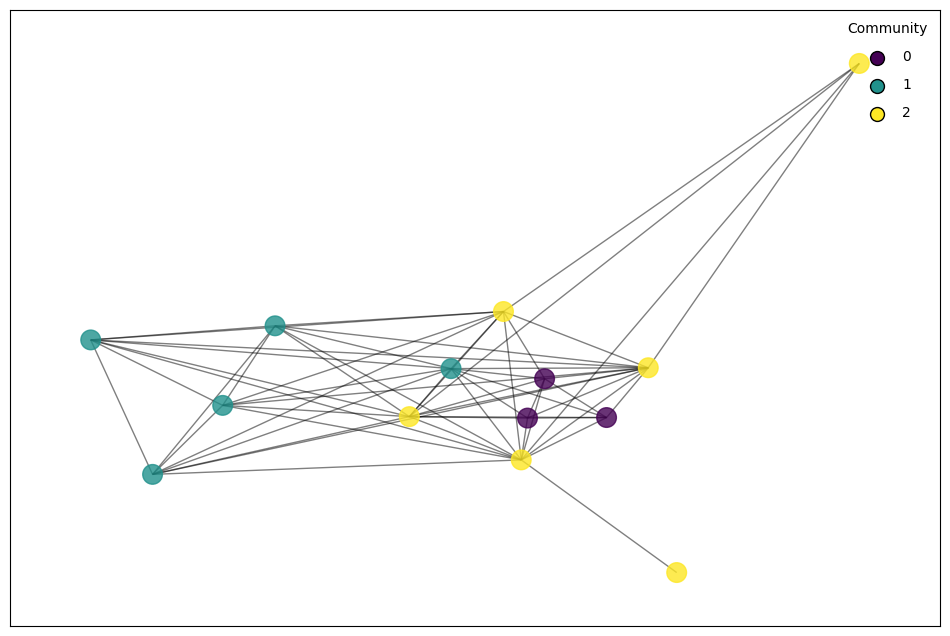

In [57]:
G20_filtered = filtered_graphs['G20']

partition, modularity = compute_partition_and_modularity(G20_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G20_filtered, partition, layout='kamada-kawai')

#### Village Affiliations Based Partitioning Results

Modularity: 0.12257777777777783
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Gaara', 'Temari', 'Kankurō']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

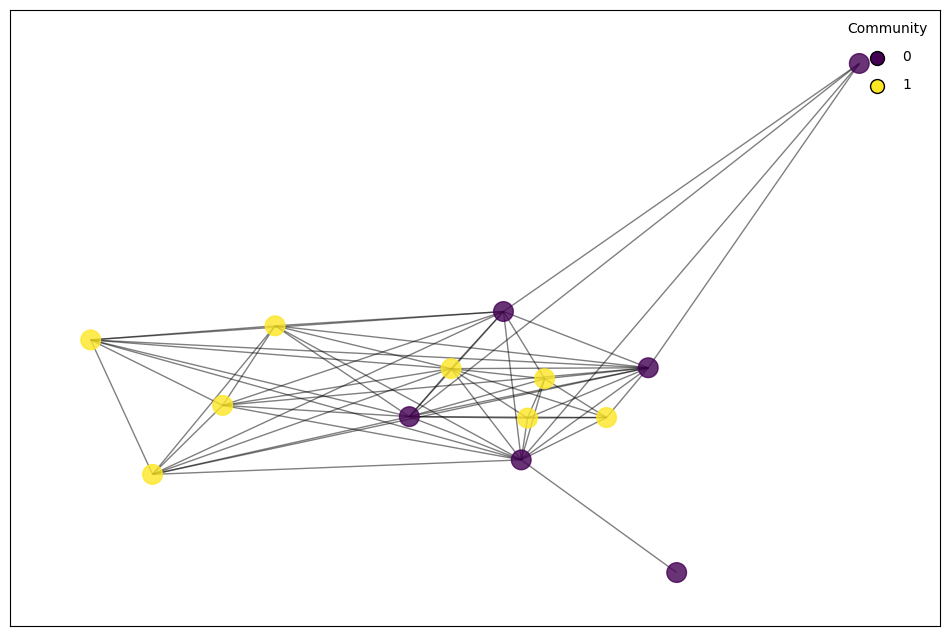

In [58]:
G20_filtered_villages = filtered_graphs['G20']

target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G20_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G20_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G20_filtered, partition, layout='kamada-kawai')

### Up to Episode 100

#### Louvain Algorithm Results

Modularity: 0.14503423783982755
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

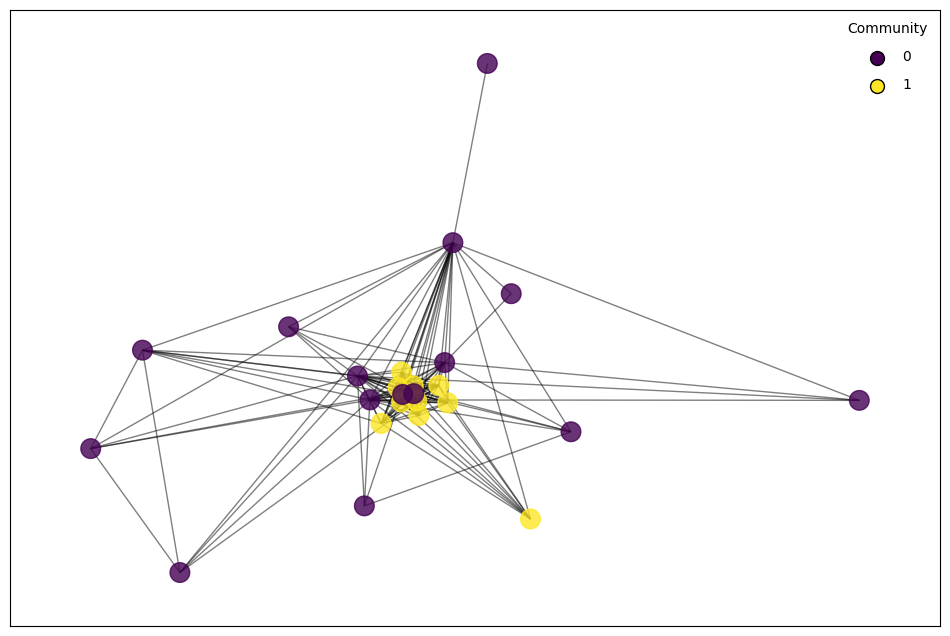

In [59]:
G100_filtered = filtered_graphs['G100']

partition, modularity = compute_partition_and_modularity(G100_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G100_filtered, partition, layout='kamada-kawai')

#### Village Affiliations Based Partitioning Results

Modularity: 0.04515738753103432
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Ino Yamanaka', 'Hinata Hyūga', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune']
Community 1: ['Shikamaru Nara', 'Gaara', 'Temari', 'Kankurō']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

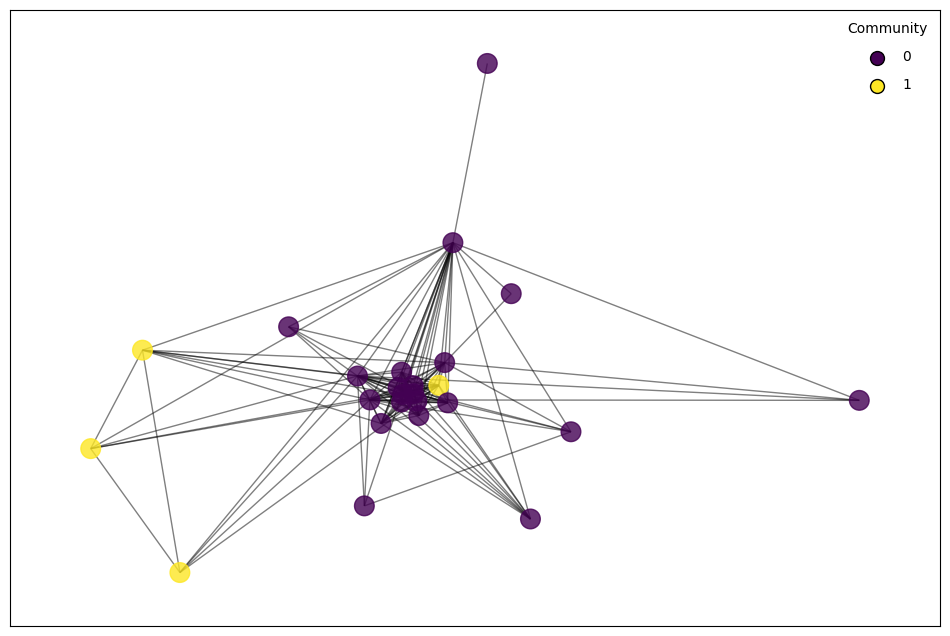

In [60]:
G100_filtered_villages = filtered_graphs['G100']

target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G100_filtered, target_villages)

partition, modularity = compute_partition_and_modularity(G100_filtered, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G100_filtered, partition, layout='kamada-kawai')

### Up to Episode 220 (Final episode of season 1)

#### Louvain Algorithm Results

Modularity: 0.12471383215470389
Community 0: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame', 'Tsunade', 'Shizune']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

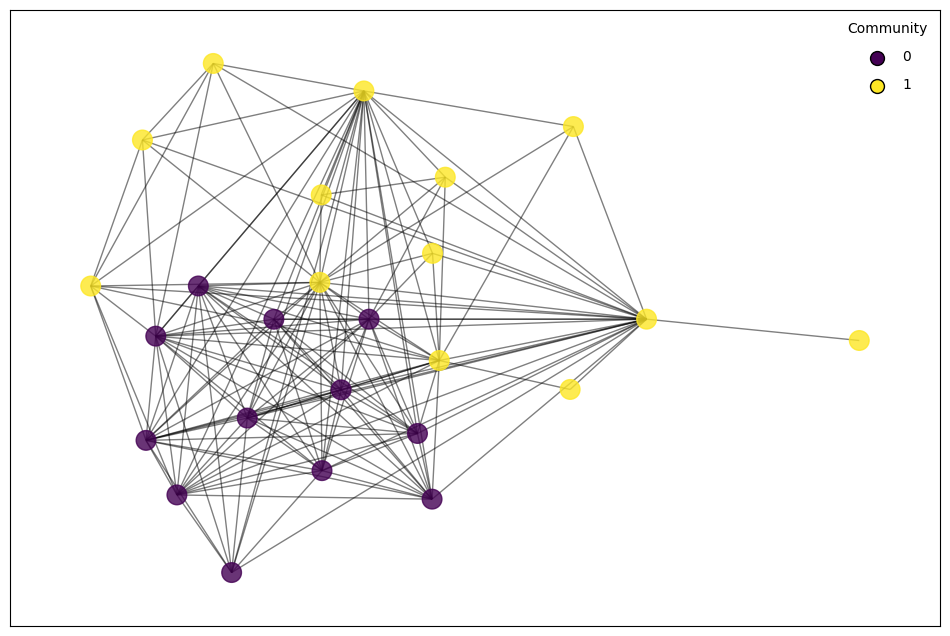

In [61]:
G220_filtered = filtered_graphs['G220']

partition, modularity = compute_partition_and_modularity(G220_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G220_filtered, partition, layout='kamada-kawai')

#### Village Affiliations Based Partitioning Results

Modularity: 0.04177728022484275
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune']
Community 1: ['Shikamaru Nara', 'Kakashi Hatake', 'Gaara', 'Temari', 'Kankurō']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

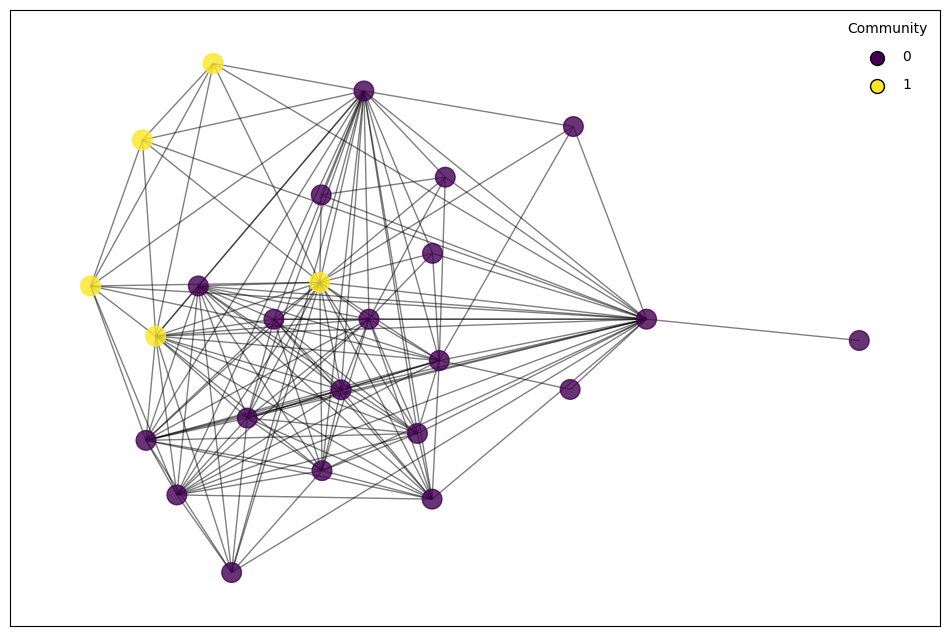

In [62]:
G220_filtered_villages = filtered_graphs['G220']

target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G220_filtered_villages, target_villages)

partition, modularity = compute_partition_and_modularity(G220_filtered_villages, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G220_filtered_villages, partition, layout='kamada-kawai')

### Up to Episode 720 (Final episode of season 2)

#### Louvain Algorithm Results

Modularity: 0.13660162737295384
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame', 'Tsunade', 'Shizune']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

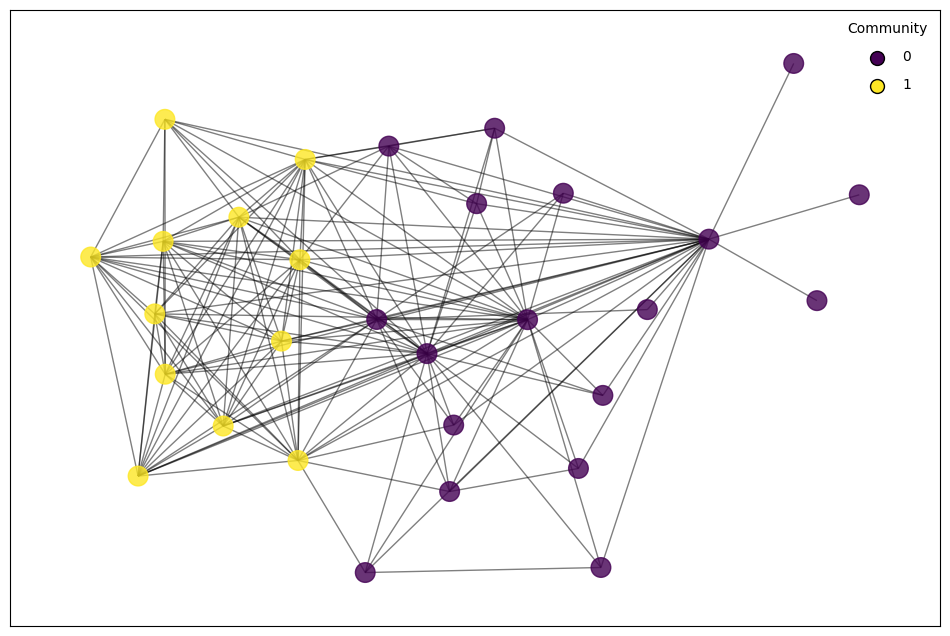

In [63]:
G720_filtered = filtered_graphs['G720']

partition, modularity = compute_partition_and_modularity(G720_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G720_filtered, partition, layout='kamada-kawai')

#### Village Affiliations Based Partitioning Results

Modularity: 0.02620625366910017
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Ino Yamanaka', 'Hinata Hyūga', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']
Community 1: ['Shikamaru Nara', 'Gaara', 'Temari', 'Kankurō']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

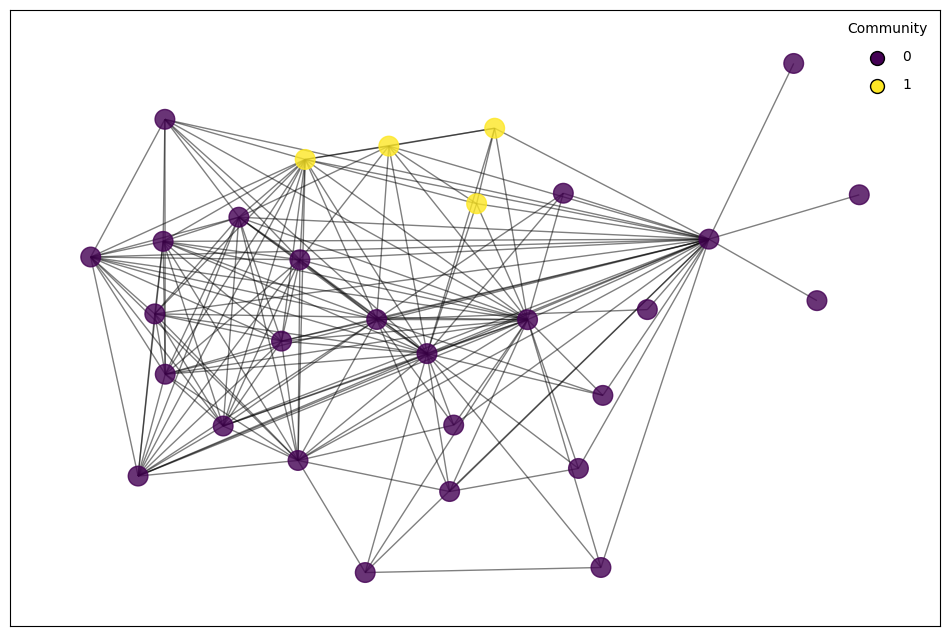

In [64]:
G720_filtered_village = filtered_graphs['G720']

target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G720_filtered_village, target_villages)

partition, modularity = compute_partition_and_modularity(G720_filtered_village, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G720_filtered_village, partition, layout='kamada-kawai')

### Up to Episode 1013 (Final episode of the series) 

#### Louvain Algorithm Results

Modularity: 0.2826874668872876
Community 0: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Kakashi Hatake', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Kabuto Yakushi', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']
Community 1: ['Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Chōji Akimichi', 'Kiba Inuzuka', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Shino Aburame', 'Tsunade', 'Shizune']
Community 2: ['Konohamaru Sarutobi', 'Boruto Uzumaki', 'Sarada Uchiha', 'Shikadai Nara', 'Chōchō Akimichi', 'Himawari Uzumaki', 'Denki Kaminarimon', 'Inojin Yamanaka', 'Iwabee Yuino', 'Metal Lee', 'Mitsuki', 'Sai Yamanaka', 'Kawaki']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

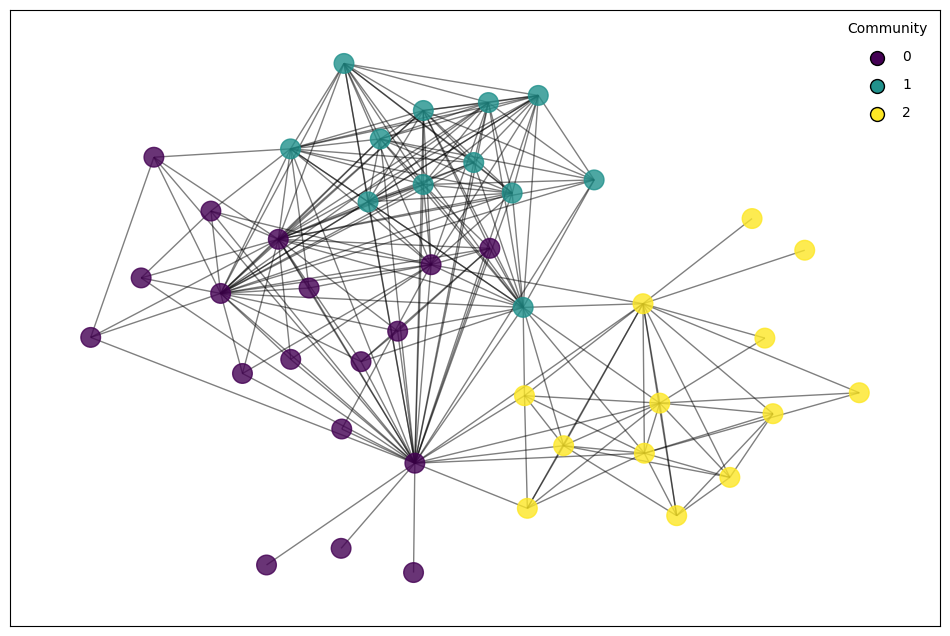

In [89]:
G1013_filtered = filtered_graphs['G1013']

partition, modularity = compute_partition_and_modularity(G1013_filtered)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered, partition, layout='kamada-kawai')

#### Village Affiliations Based Partitioning Results

Modularity: 0.2354415800407661
Community 0: ['Konohamaru Sarutobi', 'Boruto Uzumaki', 'Sarada Uchiha', 'Shikadai Nara', 'Chōchō Akimichi', 'Himawari Uzumaki', 'Denki Kaminarimon', 'Inojin Yamanaka', 'Iwabee Yuino', 'Metal Lee', 'Mitsuki', 'Sai Yamanaka', 'Kawaki']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Gaara', 'Temari', 'Kankurō', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Might Guy', 'Kabuto Yakushi', 'Shino Aburame', 'Itachi Uchiha', 'Orochimaru', 'Jiraiya', 'Tsunade', 'Shizune', 'Sai', 'Yamato', 'Obito Uchiha', 'Killer B', 'Kurama']


C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nodes = nx.draw_networkx_nodes(graph, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8, node_shape='o')
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  community_colors = dict(zip(unique_communities, plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(unique_communities)))))
C:\Users\Ata\AppData\Local\Temp\ipykernel_16276\4026341058.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should

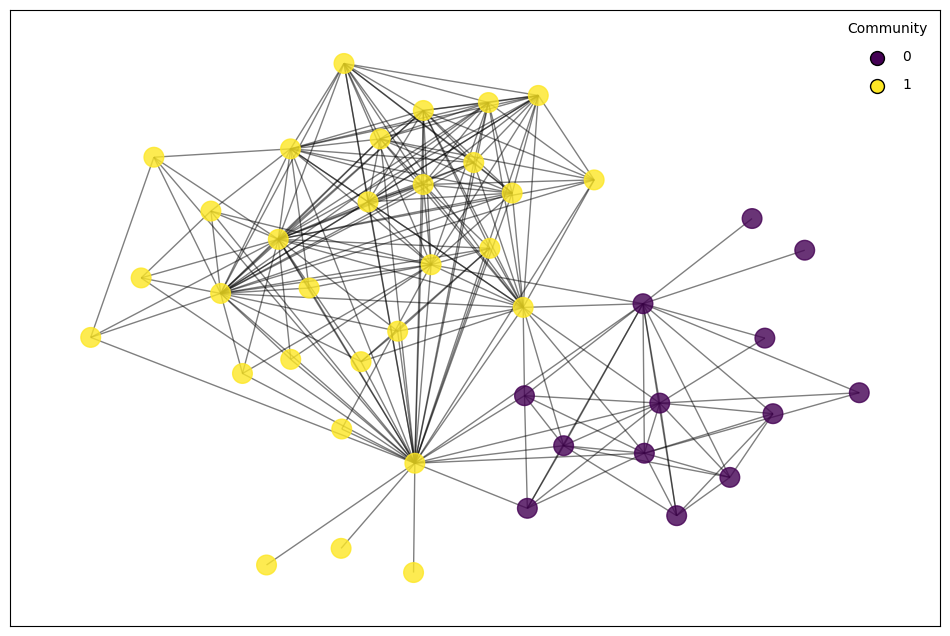

In [90]:
G1013_filtered_village = filtered_graphs['G1013']

target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]
node_community_mapping = assign_affiliation_labels(G1013_filtered_village, target_villages)

partition, modularity = compute_partition_and_modularity(G1013_filtered_village, node_community_mapping)

print(f"Modularity: {modularity}")
print_communities(partition)
visualize_network(G1013_filtered_village, partition, layout='kamada-kawai')

#### Jaccard Similarity

In [67]:
def calculate_jaccard_similarity(graph1, graph2):
    """
    Calculate Jaccard similarity between communities in two graphs.

    Parameters:
    - graph1 (networkx.Graph): The first graph.
    - graph2 (networkx.Graph): The second graph.

    Returns:
    - jaccard_similarities (list): List of dictionaries containing Jaccard similarity
                                    between pairs of communities.
                                      - 'Community1': Label of the community in graph1.
                                      - 'Community2': Label of the community in graph2.
                                      - 'Jaccard Similarity': Jaccard similarity coefficient.

    This function computes the Jaccard similarity between communities in two given graphs.
    It assumes that each node in the graphs has a 'community' attribute indicating its
    membership in a particular community. The Jaccard similarity is calculated as the
    size of the intersection of two communities divided by the size of their union.
    """

    communities_graph1 = nx.get_node_attributes(graph1, 'community')
    communities_graph2 = nx.get_node_attributes(graph2, 'community')

    # Calculate Jaccard similarity for all pairs of communities
    jaccard_similarities = []
    for community1, community2 in product(set(communities_graph1.values()), set(communities_graph2.values())):
        members1 = get_community_members(graph1, community1)
        members2 = get_community_members(graph2, community2)

        # Create binary vectors indicating membership for all nodes in the union of both communities
        all_nodes = set(members1 + members2)
        binary_vector1 = np.array([node in members1 for node in all_nodes], dtype=int)
        binary_vector2 = np.array([node in members2 for node in all_nodes], dtype=int)

        jaccard_similarity = jaccard_score(binary_vector1, binary_vector2)

        jaccard_similarities.append({
            'Community1': community1,
            'Community2': community2,
            'Jaccard Similarity': jaccard_similarity
        })

    return jaccard_similarities


def get_community_members(graph, community):
    """
    Returns the node names of the community members.

    Parameters:
    - graph: NetworkX graph
    - community: name of thr community as string
    """
    return [node for node, data in graph.nodes(data=True) if data['community'] == community]

#### Comparing Jaccard Similarities of Communities for the Temporal Evolution of Series

In [93]:
jaccard_similarities = calculate_jaccard_similarity(G20_filtered, G100_filtered)

for similarity in jaccard_similarities:
    print(similarity)

{'Community1': 0, 'Community2': 0, 'Jaccard Similarity': 0.2857142857142857}
{'Community1': 0, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 0, 'Jaccard Similarity': 0.16}
{'Community1': 1, 'Community2': 1, 'Jaccard Similarity': 0.5}


In [69]:
jaccard_similarities = calculate_jaccard_similarity(G100_filtered, G720_filtered)

for similarity in jaccard_similarities:
    print(similarity)

{'Community1': 0, 'Community2': 0, 'Jaccard Similarity': 0.8076923076923077}
{'Community1': 0, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 0, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 1, 'Jaccard Similarity': 1.0}


In [70]:
jaccard_similarities = calculate_jaccard_similarity(G720_filtered, G1013_filtered)

for similarity in jaccard_similarities:
    print(similarity)

{'Community1': 0, 'Community2': 0, 'Jaccard Similarity': 0.9629629629629629}
{'Community1': 0, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 0, 'Community2': 2, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 0, 'Jaccard Similarity': 0.03333333333333333}
{'Community1': 1, 'Community2': 1, 'Jaccard Similarity': 0.0}
{'Community1': 1, 'Community2': 2, 'Jaccard Similarity': 0.75}
